# Naive Bayes 朴素贝叶斯

## 贝叶斯公式
$$
    P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}
$$

## 条件独立假设
$$
\begin{align}
    P(\boldsymbol X=\boldsymbol x|Y = y_k) &= P(X_1=x_1 ,... ,X_N=x_N|Y = y_k) \\
                                           &= \prod_{i=1}^N P(X_i=x_i|Y = y_k)
\end{align}
$$

## 朴素贝叶斯方法
$$
\begin{align}
    P(Y = y_k|\boldsymbol X=\boldsymbol x) &= \frac{P(\boldsymbol X=\boldsymbol x|Y = y_k) \cdot P(Y = y_k)} {P(\boldsymbol X=\boldsymbol x)} \\
                                           &= \frac{P(Y = y_k) \cdot \prod_{i=1}^N P(X_i=x_i|Y = y_k)} {\prod_{i=1}^N P(X_i=x_i)}
\end{align}
$$


$$
\begin{align}
    f(x) &= arg \max_{y\in Y} P(Y = y_k|\boldsymbol X=\boldsymbol x) \\
         &= arg \max_{y\in Y} P(Y = y_k) \cdot \prod_{i=1}^N P(X_i=x_i|Y = y_k)
\end{align}
$$

朴素贝叶斯方法通常处理分类问题，$Y$ 为离散量

$$
    P(Y=y_k) = \frac {\sum_{i=1}^N I(y_i = y_k)} {N}
$$

若 $X_k$ 也为离散量，则计算方法与 $Y$ 相同

若 $X_k$ 为连续量，则猜测其符合某种概率分布，以正态分布为例：

$$
p(x) = \frac {1} {\sigma \sqrt {2\pi}} e^{-\frac {(x-\mu)^2} {2\sigma^2}}
$$

## 实现

In [1]:
import numpy as np
import pandas as pd
import metrics as mc

In [2]:
def GaussProb(x,mean,std):
    exp = np.exp(-(np.power(x-mean,2))/(2*np.power(std,2)))
    p = exp/std/np.sqrt(2*np.pi)
    return p

In [3]:
class NaiveBayes:
    def __init__(self, X=None, Y=None, xType=None):
        if X is not None and Y is not None:
            self.fit(X, Y, xType)
         
    def _cal_y_prob(self, Y):
        # 计算 P(Y=yk)
        self._Y_class, self._Pyk = np.unique(Y, return_counts=True)
        self._Pyk = self._Pyk/len(Y)
    
    def _cal_xi_prob_ifyk(self, X, Y, xType):
        # 计算 P(Xi=xi|Y=yk)
        self.xType = xType
        if self.xType is None:
            self.xType = np.zeros(X.shape[1])
            
        self._xi_prob_ifyk = []
        
        for Xi, t in zip(X.T, self.xType):
            if t == 0: # 离散量
                Xi_class = np.unique(Xi)
                Xi_dir = {}
                for x in Xi_class:
                    x_list = []
                    for y in self._Y_class:
                        tmp = Xi[Y==y]
                        P = ((tmp == x).sum()+1)/(len(tmp)+len(Xi_class))
                        x_list.append(P)
                    Xi_dir[x] = np.array(x_list)
                self._xi_prob_ifyk.append(Xi_dir)
            elif t == 1: # 连续量
                Xi_list = []
                for y in self._Y_class:
                    tmp = Xi[Y==y]
                    s = [tmp.mean(), tmp.std()]
                    Xi_list.append(s)
                self._xi_prob_ifyk.append(np.array(Xi_list))
            else: 
                raise ValueError('输入量类型错误：0 为离散量；1 为连续量')
        return
            
        
    def _get_xi_prob_ifyk(self, x, i):
        if self.xType[i] == 0:
            return self._xi_prob_ifyk[i][x]
        if self.xType[i] == 1:
            mean = self._xi_prob_ifyk[i][0]
            std = self._xi_prob_ifyk[i][1]
            return GaussProb(x, mean, std)
            
    def fit(self, X, Y, xType=None):
        # 计算先验概率: P(y=ck)
        self._cal_y_prob(Y)
        
        # 计算条件概率: P(Xi=xi|Y=yk)
        self._cal_xi_prob_ifyk(X, Y, xType)
        
        return
    
    def _predict_once(self, X):
        res = [self._Pyk]
        for i,x in enumerate(X):
            res += self._get_xi_prob_ifyk(x,i)
        res = np.array(res)
        prob = np.prod(res, axis=0)
        return prob/prob.sum()
    
    def predict(self, X, return_Prob=False):
        probs = np.array([self._predict_once(x) for x in X])
        classify = np.array([self._Y_class[i] for i in np.argmax(probs, axis=1)])
        if return_Prob:
            return classify, probs
        else:
            return classify

## 测试
[Heart Failure Prediction Dataset](https://www.kaggle.com/fedesoriano/heart-failure-prediction)

二分类问题

In [4]:
df = pd.read_csv('heart.csv')

In [5]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
# 由于朴素贝叶斯不受计数顺序影响，所以采用标签分类即可
NoCatList = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for s in df:
    if s not in NoCatList:
        df[s] = df[s].astype('category').cat.codes

In [7]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [8]:
df = df.sample(frac=1)
TrainX = df.values[:800, :-1]
TrainY = df.values[:800, -1]
TestX = df.values[800:, :-1]
TestY = df.values[800:, -1]

In [9]:
classifier = NaiveBayes(X=TrainX, Y=TrainY, xType=[1,0,0,1,1,0,0,1,0,1,0])

In [10]:
PreY, ProbY = classifier.predict(TestX, return_Prob=True)

In [11]:
mc.singleMetics(PreY, TestY)

{'TP': 54,
 'FP': 6,
 'FN': 10,
 'TN': 48,
 'Accuracy': 0.864406779661017,
 'Precision': 0.9,
 'Recall': 0.84375,
 'F1': 0.870967741935484}

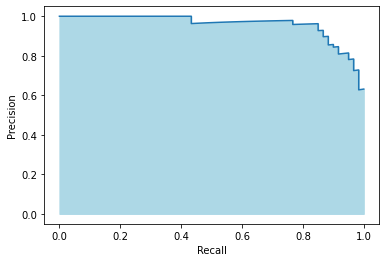

In [12]:
mc.PRcurve(ProbY[:,1], TestY, plot=True);

In [13]:
mc.AP(ProbY[:,1], TestY)

0.9557192000220713

In [14]:
mc.BEP(ProbY[:,1], TestY)

0.8833333333333333

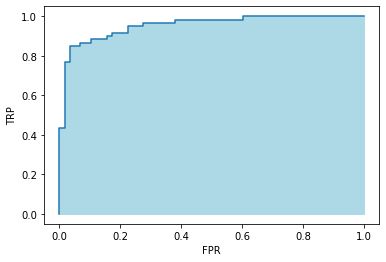

In [15]:
mc.ROCcurve(ProbY[:,1], TestY, plot=True);

In [ ]:
mc.AUC(ProbY[:,1], TestY)